# Calculating the Climatological and Anomaly Values for Selected CBP Stations

## Notebook Overview
- Select Chesapeake Bay Program (CBP) stations with sufficient SST observation temporal coverage at the appropriate depths to compute a climatology.
- Extract one SST value at each location and day, if there are observations at multiple depths.
- Compute the seasonal climatology of the mixed layer from the chosen stations.
- Compute the observed SST anomalies.
- Save the observed SST values, the climatological value, and the observed SST anomaly for location and observation day.

### Supplemental information
- [Chesapeake Bay Program station names](https://d18lev1ok5leia.cloudfront.net/chesapeakebay/documents/map_of_mainstem_and_tributary_monitoring_stations.pdf)
- [Chesapeake Bay Program data guide](https://d18lev1ok5leia.cloudfront.net/chesapeakebay/documents/cbwqdb2004_rb.pdf)

## Analysis

In [35]:
import os
from pathlib import Path

import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import seaborn as sns

Update the `REPO_ROOT` to the location of the `chesapeake_mhw` folder on your machine.

In [36]:
SAVE_FIGS = True
REPO_ROOT = Path('/Users/rwegener/repos/chesapeake_mhw')

### Read Data

In [37]:
# Read the csv into a pandas dataframe
cols = ['EventId', 'Station', 'SampleDate', 'SampleTime', 'Unit',
        'Depth', 'Layer','MeasureValue', 'Latitude', 'Longitude']
path = REPO_ROOT / 'data/01_raw/WaterQuality_ChesapeakeBayProgram_20030101_20231231_Temp.csv'
wq = pd.read_csv(path, usecols=cols, parse_dates=[2])

### Filter, Average, and Save Raw SST Observations

In [38]:
# Only consider measurements between 1 and 3 meters depth
wq_stations = wq[(wq.Depth > 1) & (wq.Depth < 3)]

In [39]:
# Take average value of observations at those depths
wq_stations = wq_stations.groupby(['Station', 'SampleDate']).mean(numeric_only=True).reset_index()

In [40]:
# Clean un-needed columns
wq_stations = wq_stations.drop(['EventId', 'Depth'], axis=1)
wq_stations = wq_stations.rename(columns={'MeasureValue': 'sst_cbp'})

File has one SST value per lat/lon/date. Values are the average of all the observations between 1m and 3m depth.

In [41]:
# Save output
path = (
    REPO_ROOT / 'data/02_interim' / 'cbp_sst_depthaveraged.csv'
    # 'cbp_stations_climatology_raw_filtered.csv' # TODO rename this. It isn't a clim and filtered
    # is pretty vague
)
wq_stations.to_csv(path, index=False)

In [42]:
wq_stations

,Station,SampleDate,sst_cbp,Latitude,Longitude
0,1AAUA001.39,2007-03-22,8.300,38.40000,-77.32000
1,1AAUA001.39,2007-06-18,26.200,38.40000,-77.32000
2,1AAUA001.39,2007-10-29,14.500,38.40000,-77.32000
3,1AAUA001.39,2007-12-10,5.200,38.40000,-77.32000
4,1AAUA001.39,2008-02-04,4.900,38.40000,-77.32000
...,...,...,...,...,...
37295,YRK031.24,2008-07-22,29.460,37.50465,-76.79252
37296,YRK031.24,2008-08-22,26.455,37.50465,-76.79252
37297,YRK031.24,2008-09-17,25.105,37.50465,-76.79252
37298,YRK031.24,2008-10-16,21.134,37.50465,-76.79252


### Preprocessing

In [43]:
# Create a list of all the station names
stations = wq_stations.groupby('Station').count().index

In [44]:
# Create a dataframe with the number of observations per station and month
counts = wq_stations.groupby(['Station', wq_stations.SampleDate.dt.year, wq_stations.SampleDate.dt.month]).count()['sst_cbp']
# Format the dataframe more clearly
counts = pd.DataFrame(counts)
counts = counts.rename(columns={'sst_cbp': 'ObsCount'})
counts.index = counts.index.set_names(['Station', 'year', 'month'])

### Create a list of stations that have enough data to compute a climatology

Create a filtered list of stations that have at least 12 years of observations in all months and 18 observations in 10 of the months.

In [45]:
stations_filtered = []  # TODO rename to clim_elibigle_stations
completeness_df = pd.DataFrame(
    columns = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 
               'Nov', 'Dec']
)

for station in stations:
    # extract station
    df = counts.loc[station]
    # preprocessing
    df = df.reset_index()
    matrix = df.pivot(index='year', columns='month')
    
    # Add to filtered stations if it meets the condition
    if (matrix.sum() < 12).sum() > 0:
        # If any month does not have at least 12 years with an obs (~60% coverage)
        # do not consider it
        continue
    # Check that there are at least 18 months with obs (~90% coverage) in 10 of the months
    if ((~matrix.isna()).sum() >= 18).sum() >= 10:
        stations_filtered.append(station)
        # optional - plot a heatmap for the individual station
        # sns.heatmap(matrix)
        # plt.title(station)
        # plt.show()
        # plt.close()
        completeness_df.loc[station] = (~matrix.isna()).sum().values

print(len(stations_filtered), 'stations identified.')

51 stations identified.


### Filter stations list to only include climatology-eligible stations

In [46]:
wq_stations = wq_stations[wq_stations.Station.isin(stations_filtered)]

### Plot location of the climatology stations

In [47]:
wq_counts = wq_stations.groupby('Station').mean(numeric_only=True)[['Latitude', 'Longitude']]
wq_counts['Count'] = wq_stations.groupby('Station').count()['sst_cbp']

In [48]:
geoWQ = gpd.GeoDataFrame(
    wq_counts, geometry=gpd.points_from_xy(wq_counts['Longitude'], wq_counts['Latitude']), 
    crs='epsg:4326')

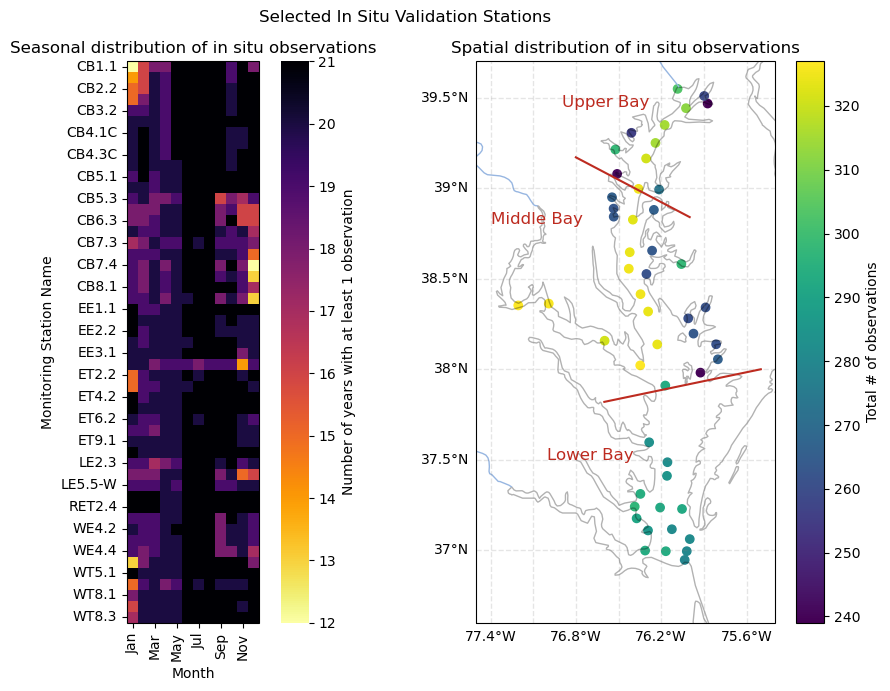

In [49]:
# ax1 = plt.subplot(121)
# ax2 = plt.subplot(122, projection=ccrs.PlateCarree())
fig, axes = plt.subplots(1, 2, subplot_kw={'projection': ccrs.PlateCarree()}, 
                         # gridspec_kw={'width_ratios':[5, 2]}, 
                         figsize=(10, 7))
                        # gridspec_kw={'width_ratios':[2, 1]})  # , 'height_ratios':[2,1]})
fig.suptitle('Selected In Situ Validation Stations')

# fig.set_size_inches(9, 6)
# fig.suptitle('Locations of most frequently sampled in situ locations')

# Add background features
axes[1].add_feature(cfeature.COASTLINE, alpha=0.3)
axes[1].add_feature(cfeature.BORDERS, linestyle=':')
axes[1].add_feature(cfeature.RIVERS)
# ax.coastlines()

axes[1].set_extent([-77.5, -75.4, 36.6, 39.7])

# Add and format gridlines. Remove top and right labels
gl = axes[1].gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.2, linestyle='--')
gl.top_labels, gl.right_labels = False, False

# Add seasonal distribution
# attempted and failed to make colorbar discrete
# making colorbar discrete is fine; struggling with label location
# cmap = plt.get_cmap('inferno_r', np.max(completeness_df.values) - np.min(completeness_df.values) + 1)
axes[0].set_title('Seasonal distribution of in situ observations')
sns.heatmap(completeness_df, ax=axes[0], cmap='inferno_r',
                   # linewidths=0.2,
            cbar_kws={'label': 'Number of years with at least 1 observation'})
axes[0].set_ylabel('Monitoring Station Name')
axes[0].set_xlabel('Month')
axes[0].set_xticks([0.5, 2.5, 4.5, 6.5, 8.5, 10.5])
axes[0].set_xticklabels(['Jan','Mar','May','Jul', 'Sep', 'Nov'])

# Plot in situ locations
axes[1].set_title('Spatial distribution of in situ observations')
geoWQ.plot(ax=axes[1], column='Count', legend=True, legend_kwds={'label': "Total # of observations"})
# Add upper / middle / lower locations
axes[1].plot([-76.8, -76.0], [39.17, 38.84], color='#bd2b20')  # upper/mid
axes[1].plot([-76.6, -75.5], [37.82, 38], color='#bd2b20')  # mid/lower
axes[1].text(-76.9, 39.45, 'Upper Bay', color='#bd2b20', size=12)
axes[1].text(-77.4, 38.8, 'Middle Bay', color='#bd2b20', size=12)
axes[1].text(-77.0, 37.5, 'Lower Bay', color='#bd2b20', size=12)


plt.tight_layout()

if SAVE_FIGS: 
    plt.savefig(REPO_ROOT / 'figures/02_validation/insitu_distribution.png', 
                dpi=400, bbox_inches='tight')

**Most sampled stations from several areas of the bay**

- CB5.1 -- main stem outside the Patuxent River
- RET2.4 -- up the Potomac River
- CB7.2 -- main stem near the exit of the Bay

In [50]:
len(stations_filtered)

51

## Compute the Climatologial Value for each Depth and Location

It's possible this observation count isn't strictly necessary for the process, it was something I did while just trying to get a handle on how many values there were.

In [51]:
wq_stations.sort_values(['Station', 'SampleDate'])

,Station,SampleDate,sst_cbp,Latitude,Longitude
378,CB1.1,2003-01-15,1.10,39.54794,-76.08481
379,CB1.1,2003-03-12,2.40,39.54794,-76.08481
380,CB1.1,2003-04-09,6.90,39.54794,-76.08481
381,CB1.1,2003-04-23,12.40,39.54794,-76.08481
382,CB1.1,2003-05-07,18.10,39.54794,-76.08481
...,...,...,...,...,...
28874,WT8.3,2023-08-08,27.40,38.84250,-76.53410
28875,WT8.3,2023-09-13,27.80,38.84250,-76.53410
28876,WT8.3,2023-10-17,16.75,38.84250,-76.53410
28877,WT8.3,2023-11-16,11.10,38.84250,-76.53410


In [52]:
# Determine how many observations there are for each station in each month/year
counts = wq_stations.groupby(
    ['Station', wq_stations.SampleDate.dt.year, wq_stations.SampleDate.dt.month]
).count()['sst_cbp']
counts = pd.DataFrame(counts)
counts = counts.rename({'sst_cbp': 'ObsCount'}, axis=1)
counts.index = counts.index.set_names(['Station', 'year', 'month'])

In [53]:
# not used?
# counts['avg_sst'] = wq_stations.groupby(
#     ['Station', wq_stations.SampleDate.dt.month]
# )['sst_cbp'].mean()

In [54]:
counts

ObsCount
Station year month          
CB1.1   2003 1             1
             3             1
             4             2
             5             2
             6             1
...                      ...
WT8.3   2023 8             1
             9             1
             10            1
             11            1
             12            1

[12193 rows x 1 columns]

In [55]:
# wq_stations[['Station', 'SampleDate']] \
#     .to_csv(REPO_ROOT / 'data/interim' / 'intermediate_anomaly_stations_for_dates.csv')

In [56]:
wq_stations[['Station', 'SampleDate']].to_csv(
    REPO_ROOT / 'data/02_interim' / 'climatology_station_dates.csv',
    index=False,
)

In [57]:
wq_clim = wq_stations.groupby(
    ['Station', wq_stations.SampleDate.dt.month]
)['sst_cbp'].mean(numeric_only=True)

In [58]:
wq_clim = wq_clim.dropna().sort_index().reset_index()  \
    .rename(columns={'SampleDate': 'Month', 'sst_cbp': 'clim_cbp'})

## Compute Anomalies

In [59]:
wq_stations['Month'] = wq_stations.SampleDate.dt.month

/var/folders/nb/y7dp0ct55_58hrhrhlz5vbkm0000gn/T/ipykernel_929/3673797116.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wq_stations['Month'] = wq_stations.SampleDate.dt.month


In [60]:
wq.sort_values(['Station', 'SampleDate'])

,EventId,Station,SampleDate,SampleTime,Depth,Layer,MeasureValue,Unit,Latitude,Longitude
74429,20932.0,1AAUA001.39,2007-03-22,10:25:00,1.00,S,8.40,DEG C,38.40000,-77.32000
74446,20932.0,1AAUA001.39,2007-03-22,10:25:00,1.50,B,8.30,DEG C,38.40000,-77.32000
74447,20932.0,1AAUA001.39,2007-03-22,10:25:00,0.50,S,8.40,DEG C,38.40000,-77.32000
81492,7872.0,1AAUA001.39,2007-06-18,11:47:00,0.50,S,26.30,DEG C,38.40000,-77.32000
81516,7872.0,1AAUA001.39,2007-06-18,11:47:00,1.00,S,26.30,DEG C,38.40000,-77.32000
...,...,...,...,...,...,...,...,...,...,...
116710,81436.0,YRK031.24,2008-11-20,13:45:00,0.50,VP,9.99,DEG C,37.50465,-76.79252
116711,81436.0,YRK031.24,2008-11-20,13:45:00,0.25,VP,10.00,DEG C,37.50465,-76.79252
116727,81436.0,YRK031.24,2008-11-20,13:45:00,1.50,VP,9.93,DEG C,37.50465,-76.79252
116760,81436.0,YRK031.24,2008-11-20,13:45:00,0.10,VP,10.00,DEG C,37.50465,-76.79252


In [61]:
wq_clim

,Station,Month,clim_cbp
0,CB1.1,1,4.050000
1,CB1.1,2,2.943750
2,CB1.1,3,5.750000
3,CB1.1,4,12.520000
4,CB1.1,5,18.532143
...,...,...,...
607,WT8.3,8,27.191667
608,WT8.3,9,23.715217
609,WT8.3,10,17.254167
610,WT8.3,11,10.961905


In [62]:
wq = pd.merge(wq_stations, wq_clim, on=['Station', 'Month'])  \
    .drop(columns=['Month'])

In [63]:
wq['anom_cbp'] = wq['sst_cbp'] - wq['clim_cbp']

In [64]:
# Rearrange columns for neatness
anom_cbp = wq.pop('anom_cbp')
wq.insert(3, anom_cbp.name, anom_cbp)

In [65]:
wq.sort_values(['Station', 'SampleDate']).reset_index(drop=True)

,Station,SampleDate,sst_cbp,anom_cbp,Latitude,Longitude,clim_cbp
0,CB1.1,2003-01-15,1.10,-2.950000,39.54794,-76.08481,4.050000
1,CB1.1,2003-03-12,2.40,-3.350000,39.54794,-76.08481,5.750000
2,CB1.1,2003-04-09,6.90,-5.620000,39.54794,-76.08481,12.520000
3,CB1.1,2003-04-23,12.40,-0.120000,39.54794,-76.08481,12.520000
4,CB1.1,2003-05-07,18.10,-0.432143,39.54794,-76.08481,18.532143
...,...,...,...,...,...,...,...
14739,WT8.3,2023-08-08,27.40,0.208333,38.84250,-76.53410,27.191667
14740,WT8.3,2023-09-13,27.80,4.084783,38.84250,-76.53410,23.715217
14741,WT8.3,2023-10-17,16.75,-0.504167,38.84250,-76.53410,17.254167
14742,WT8.3,2023-11-16,11.10,0.138095,38.84250,-76.53410,10.961905


In [66]:
# Save data
path = (
    REPO_ROOT / 
    'data/02_interim' /  
    # 'cbp_temps_selected_stations_with_climatology.csv'
    'cbp_ssta_selected_stations_with_climatology.csv'
)
wq.to_csv(path, index=False)